In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import tf2lib as tl
import tf2gan as gan
import DLlib as dl
import pylib as py
import wflib as wf
import data

import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
dataset_dir = '../datasets/'
dataset_hdf5_1 = 'Bip_NRef_384_complex_2D.hdf5'
valX, valY, TE = data.load_hdf5(dataset_dir, dataset_hdf5_1, ech_idx=24, te_data=True, MEBCRN=True)

valX = valX[:,:,::2,::2,:]
valY = valY[:,:,::2,::2,:]

hgt = valX.shape[2]
wdt = valX.shape[3]

A_B_dataset_val = tf.data.Dataset.from_tensor_slices((valX,valY, TE)).batch(1)
val_iter = cycle(A_B_dataset_val)

fm_sc = 300.0
r2_sc = 200.0

In [3]:
# Create VET-Net and load weights
experiment_dir = py.join('output','TEaug-305')
args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))

if not(hasattr(args,'bip_grad')):
    py.arg('--bip_grad', type=bool, default=False)
    BG_args = py.args()
    args.__dict__.update(BG_args.__dict__)

if args.G_model == 'multi-decod':
    input_shape = (None,None,None,2)
    G_A2B = dl.PM_Generator(input_shape=input_shape, te_input=args.te_input, te_shape=(None,), filters=args.n_G_filters)
    tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()
elif args.G_model == '2U-Net':
    if args.bip_grad:
        bip_out = 1
    else:
        bip_out = 0
    input_shape = (None,None,None,1)
    G_A2B = dl.UNet(input_shape=(None,None,None,2), n_out=1+bip_out, ME_layer=True, te_input=args.te_input, te_shape=(None,),
                    filters=args.n_G_filters, self_attention=args.D1_SelfAttention)
    G_A2R2= dl.UNet(input_shape=(None,None,None,1), ME_layer=True, te_input=args.te_input, te_shape=(None,),
                    filters=args.n_G_filters, output_activation='sigmoid', self_attention=args.D2_SelfAttention)
    tl.Checkpoint(dict(G_A2B=G_A2B,G_A2R2=G_A2R2), py.join(experiment_dir, 'checkpoints')).restore()

In [ ]:
experiment_dir = py.join('output','single-102')
args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))

if args.grad_mode == 'bipolar':
    bip_pha_out = 1
else:
    bip_pha_out = 0

G_mag = dl.UNet(input_shape=(None,None,None,1),n_out=3,ME_layer=True,filters=args.n_G_filters,output_activation='sigmoid',
                self_attention=args.D1_SelfAttention)
G_pha = dl.UNet(input_shape=(None,None,None,1),n_out=3+bip_pha_out,ME_layer=True,filters=args.n_G_filters,
                output_activation='linear',self_attention=args.D2_SelfAttention)

tl.Checkpoint(dict(G_mag=G_mag,G_pha=G_pha), py.join(experiment_dir, 'checkpoints')).restore()

In [4]:
IDEAL_op = wf.IDEAL_Layer()

In [5]:
# Sample function
@tf.function
def sample(A, TE):
    if args.G_model == 'multi-decod':
        A2B_PM = G_A2B([A,TE], training=False)
        A2B_PM = tf.where(A[:,:1,:,:,:]!=0.0,A2B_PM,0.0)
    elif args.G_model == '2U-Net':
        A_abs = tf.math.sqrt(tf.reduce_sum(tf.square(A),axis=-1,keepdims=True))
        A_pha = tf.math.atan2(A[...,1:],A[...,:1])
        A2B_R2 = G_A2R2([A_abs,TE], training=False)
        if args.bip_grad:
            A2B_FM = G_A2B([A,TE], training=False)
            A2B_FM = tf.transpose(A2B_FM, perm=[0,4,2,3,1])
            A2B_R2 = tf.concat([A2B_R2,tf.zeros_like(A2B_R2)],axis=1)
            A2B_PM = tf.concat([A2B_FM,A2B_R2],axis=-1)
            A2B_PM = tf.where(A[:,:2,...]!=0.0,A2B_PM,0.0)
        else:
            A2B_FM_odd = G_A2B([A[:,::2,...],TE[:,1::2]], training=False)
            A2B_FM_evn = G_A2B([A[:,1::2,...],TE[:,1::2]], training=False)
            A2B_PM_odd = tf.concat([A2B_FM_odd,A2B_R2],axis=-1)
            A2B_PM_odd = tf.where(A[:,:1,...]!=0.0,A2B_PM_odd,0.0)
            A2B_PM_evn = tf.concat([A2B_FM_evn,A2B_R2],axis=-1)
            A2B_PM_evn = tf.where(A[:,:1,...]!=0.0,A2B_PM_evn,0.0)
    A2B_WF = wf.get_rho(A, A2B_PM, field=args.field, te=TE)
    A2B = tf.concat([A2B_WF,A2B_PM],axis=1)
    return A2B

def test(A, TE=None):
    A2B = sample(A, TE)
    return A2B

In [ ]:
# Sample function
@tf.function
def sample(A, te=None):
    A_mag = tf.math.sqrt(tf.reduce_sum(tf.square(A),axis=-1,keepdims=True))
    A_pha = tf.math.atan2(A[...,1:],A[...,:1]) / np.pi
    # Compute model's output
    A2B_mag = G_mag(A_mag, training=True)
    A2B_pha = G_pha(A_pha, training=True)
    if args.grad_mode == 'bipolar':
        A2B_mag = tf.concat([A2B_mag,tf.zeros_like(A2B_mag[...,:1])],axis=-1)
    A2B = tf.concat([A2B_mag,A2B_pha],axis=1)
    A2B = tf.transpose(A2B, perm=[0,4,2,3,1])
    if args.grad_mode == 'bipolar':
        A2B = tf.where(A[:,:4,...]!=0.0,A2B,0.0)
    return A2B

def test(A, TE=None):
    A2B = sample(A, TE)
    return A2B

In [13]:
A, B, TE = next(val_iter)

#A = A[:,1::2,...]
#TE = TE[:,1::2,...]
print(np.squeeze(np.round(TE*1e3,1)))

A2B = test(A, TE)

[1.3 2.4 3.5 4.6 5.7 6.8]


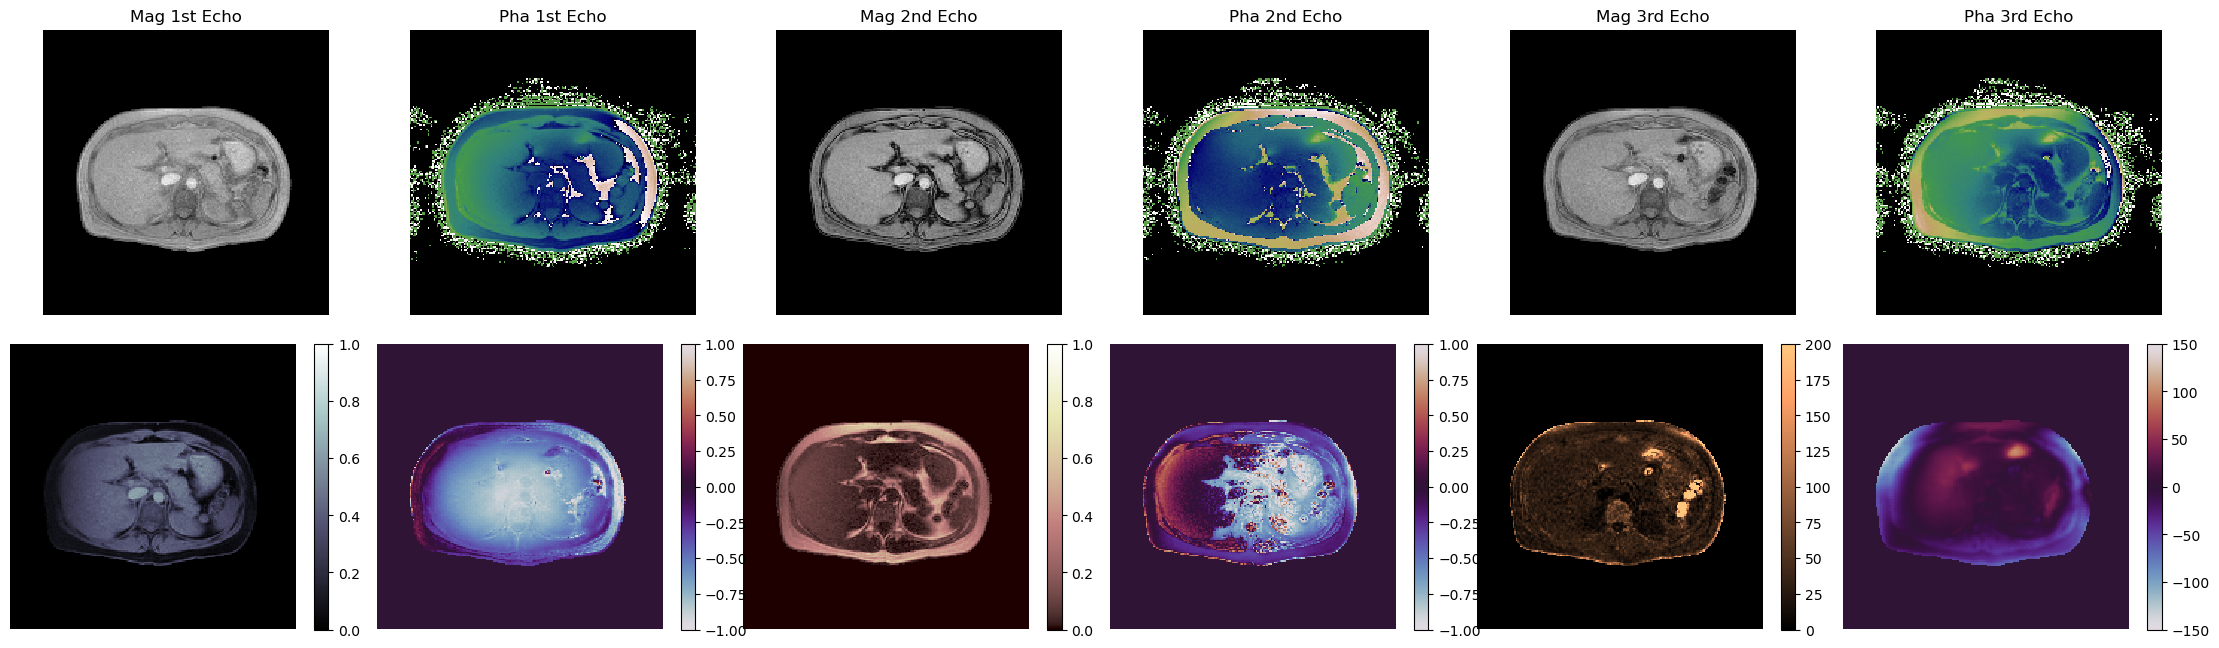

In [14]:
fig, axs = plt.subplots(figsize=(22, 6), nrows=2, ncols=6)

# Recon MR images at each echo
pha_ech1 = np.squeeze(np.arctan2(A[:,0,:,:,1],A[:,0,:,:,0]))
pha_ech2 = np.squeeze(np.arctan2(A[:,1,:,:,1],A[:,1,:,:,0]))
pha_ech3 = np.squeeze(np.arctan2(A[:,2,:,:,1],A[:,2,:,:,0]))
mag_ech1 = np.squeeze(np.abs(tf.complex(A[:,0,:,:,0],A[:,0,:,:,1])))
mag_ech2 = np.squeeze(np.abs(tf.complex(A[:,1,:,:,0],A[:,1,:,:,1])))
mag_ech3 = np.squeeze(np.abs(tf.complex(A[:,2,:,:,0],A[:,2,:,:,1])))

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(mag_ech1, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,0].set_title('Mag 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[0,1].imshow(pha_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[0,1].set_title('Pha 1st Echo')
axs[0,1].axis('off')
acq_ech3 = axs[0,2].imshow(mag_ech2, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,2].set_title('Mag 2nd Echo')
axs[0,2].axis('off')
acq_ech4 = axs[0,3].imshow(pha_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[0,3].set_title('Pha 2nd Echo')
axs[0,3].axis('off')
acq_ech5 = axs[0,4].imshow(mag_ech3, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,4].set_title('Mag 3rd Echo')
axs[0,4].axis('off')
acq_ech6 = axs[0,5].imshow(pha_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-np.pi, vmax=np.pi)
axs[0,5].set_title('Pha 3rd Echo')
axs[0,5].axis('off')

# A2B maps in the second row
w_m_aux = np.squeeze(np.abs(tf.complex(A2B[:,0,:,:,0],A2B[:,0,:,:,1])))
w_p_aux = np.squeeze(np.arctan2(A2B[:,0,:,:,1],A2B[:,0,:,:,0]))/np.pi
f_m_aux = np.squeeze(np.abs(tf.complex(A2B[:,1,:,:,0],A2B[:,1,:,:,1])))
f_p_aux = np.squeeze(np.arctan2(A2B[:,1,:,:,1],A2B[:,1,:,:,0]))/np.pi
r2_aux = np.squeeze(A2B[:,2,:,:,1])
field_aux = np.squeeze(A2B[:,2,:,:,0])

# w_m_aux = np.squeeze(A2B[:,0,:,:,0])
# w_p_aux = np.squeeze(A2B[:,0,:,:,1])
# f_m_aux = np.squeeze(A2B[:,1,:,:,0])
# f_p_aux = np.squeeze(A2B[:,1,:,:,1])
# r2_aux = np.squeeze(A2B[:,2,:,:,0])
# field_aux = np.squeeze(A2B[:,2,:,:,1])

W_ok =  axs[1,0].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[1,0])
axs[1,0].axis('off')

Wp_ok =  axs[1,1].imshow(w_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Wp_ok, ax=axs[1,1])
axs[1,1].axis('off')

F_ok =  axs[1,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[1,2])
axs[1,2].axis('off')

Fp_ok =  axs[1,3].imshow(f_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Fp_ok, ax=axs[1,3])
axs[1,3].axis('off')

r2_ok = axs[1,4].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[1,4])
axs[1,4].axis('off')

field_ok =  axs[1,5].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[1,5])
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
plt.show()

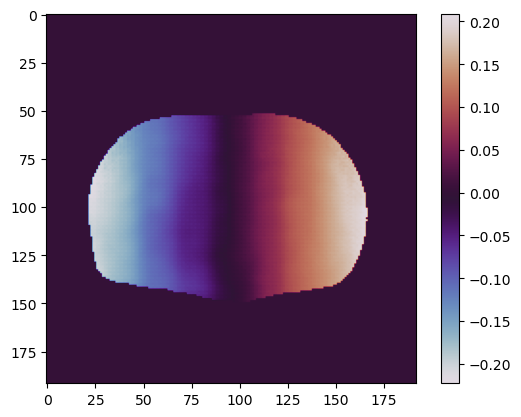

In [15]:
plt.imshow(np.squeeze(A2B[:,3,:,:,0]), cmap='twilight')
plt.colorbar()

In [ ]:
phi_even = field_aux*fm_sc

In [ ]:
phi_odd = field_aux*fm_sc

In [ ]:
mse = ((phi_even - phi_odd)**2).mean()

In [ ]:
mse

In [ ]:
plt.imshow(np.abs(phi_even-phi_odd),vmax=30.0)
plt.colorbar()
plt.axis('off')